In [1]:
#load all packages

# base packages
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from keras import metrics

# sklearn
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix

# self-build procedures
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass
from load_oasis_set import load_oasis_set
from load_oasis_set_win import load_oasis_set_win
from DataGenerator import DataGenerator

# model architectures
from cnn_backbone import base_model


### Load Train Data and oversample

In [2]:
# load dataset from drive
#PATH = "/Users/josealbertodiazsalas/Documents/Alzheimer_s Dataset/train"
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset_20percentVal\\train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False,              #<---
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )
                                        
# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))


Found 4053 files belonging to 3 classes.


### Deconstuct Train Dataset and Prepare for Oversampling

In [3]:
# seperation of validation set
# !!! these sets are not shuffled !!!

train_big = train_ds
X1_train_big = []
y1_train_big = []
X2_train_big = []
y2_train_big = []
X3_train_big = []
y3_train_big = []


for img, label in train_ds.unbatch():
    if label.numpy()[0] == 1:
        X1_train_big.append(img.numpy())
        y1_train_big.append(label.numpy())

    if label.numpy()[1] == 1:
        X2_train_big.append(img.numpy())
        y2_train_big.append(label.numpy())

    if label.numpy()[2] == 1:
        X3_train_big.append(img.numpy())
        y3_train_big.append(label.numpy())

### Oversampling
Fill classes to match class 0 (Healthy)

In [4]:
# create dataset for class 1 -NO oversampling- (healthy)
X1_train_big = np.array(X1_train_big)
y1_train_big = np.array(y1_train_big)
count1 = len(X1_train_big)

In [5]:
# oversampling for class 2 (very mild)

randomPicksIdx = [np.random.choice(len(X2_train_big)) for i in range(len(X1_train_big) - len(X2_train_big))]
count2 = len(randomPicksIdx)

for i in randomPicksIdx:
    
    X2_train_big.append(X2_train_big[i])
    y2_train_big.append(y2_train_big[i])

X2_train_big = np.array(X2_train_big)
y2_train_big = np.array(y2_train_big)

In [6]:
# oversampling for class 3 (mild)
randomPicksIdx = [np.random.choice(len(X3_train_big)) for i in range(len(X1_train_big) - len(X3_train_big))]            # images are randomly picked
count3 = len(randomPicksIdx)

for i in randomPicksIdx:
    X3_train_big.append(X3_train_big[i])
    y3_train_big.append(y3_train_big[i])

X3_train_big = np.array(X3_train_big)
y3_train_big = np.array(y3_train_big)

In [7]:
# print set sizes
print("Class 1 size:",X1_train_big.shape[0], "Increased by:", 1- count1/X1_train_big.shape[0])
print("Class 2 size:",X2_train_big.shape[0], "Increased by:", 1- count2/X2_train_big.shape[0])
print("Class 3 size:",X3_train_big.shape[0], "Increased by:", 1- count3/X3_train_big.shape[0])

Class 1 size: 2047 Increased by: 0.0
Class 2 size: 2047 Increased by: 0.7000488519785051
Class 3 size: 2047 Increased by: 0.27992183683439176


### Construct full Dataset Tensor for Training

In [8]:
# combine all data sets
X_train_fullset = np.concatenate((X1_train_big,X2_train_big,X3_train_big), axis=0)
y_train_fullset = np.concatenate((y1_train_big,y2_train_big,y3_train_big), axis=0)

In [9]:
# shuffle the whole set
X_train_temp, y_train_temp = shuffle(X_train_fullset, y_train_fullset, random_state=10)

In [10]:
# finally create tensor dataset
data_generator = DataGenerator(X_train_temp, y_train_temp, batch_size = 32)

train_fullTensor = tf.data.Dataset.from_generator(
                                            data_generator,
                                            output_signature=(tf.TensorSpec(shape=(None, 208, 176, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, 3), dtype=tf.float32))
                                            )

### Load Validation Set

In [11]:
# load validation dataset from drive
# set for training
#PATH = "/Users/josealbertodiazsalas/Documents/Alzheimer_s Dataset/train"
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset_20percentVal\\validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_fullTensor = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

Found 1016 files belonging to 3 classes.


### Check Images for Integrity

f:\env3.9.8\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


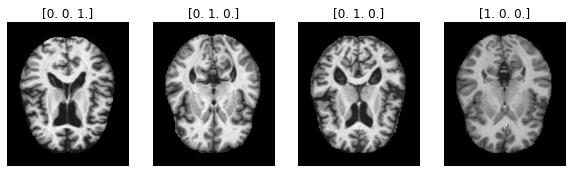

In [12]:
# plot some example images from loaded set
plt.figure(figsize=(10, 10))
for images, labels in train_fullTensor.take(10):
  for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title([labels[i].numpy()][0])
    plt.axis("off")

# Creating CNN Architecture
### First Creating Augmentation Module 

In [13]:


with tf.device("/gpu:0"):
    data_augmentation = keras.Sequential([
        layers.InputLayer(input_shape=(208, 176, 3)),
        #layers.Lambda(lambda x: tf.image.resize(x, (208, 176))),
        layers.Lambda(lambda x: tf.image.random_contrast(x,0.6,1)),
        layers.Lambda(lambda x: tf.image.random_brightness(x,0.3)),             #<--- delta value depends on image range. if 0-1 delta should be between 0-1. if 0-255 delta should be between 0-255
        layers.RandomFlip(mode="horizontal"),    
        layers.RandomRotation(0.01),
        layers.RandomZoom(0.05),
        #layers.RandomRotation(0.1),
        #layers.RandomZoom(-0.2,0.2),

])

### Check Images for proper Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


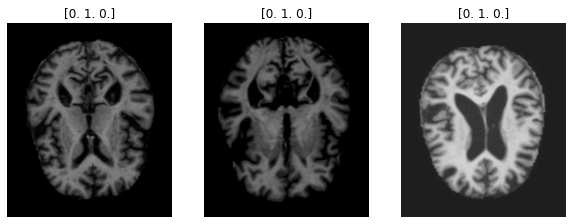

In [14]:
with tf.device("/gpu:0"):
    plt.figure(figsize=(10, 10))
    for images, labels in train_fullTensor.take(1):
        for i in range(3):
            ax = plt.subplot(1, 3, i + 1)
            img = data_augmentation(images/255)             # divided by 255 (normalization) since augmentation depends on normalization which is 
            plt.imshow(img[i].numpy(), cmap="gray")         # a specific layer in the CNN and not part of augmentation
            plt.title([labels[i].numpy()][0])
            plt.axis("off")

### Building the complete CNN
#### Construct VGG16 Backbone

In [15]:
# Defining both base and final model architecture
b_model = base_model(MODEL='VGG16', freeze_layers=False)
b_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 208, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 208, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 208, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 104, 88, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 104, 88, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 104, 88, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 52, 44, 128)       0     

### Combine Backbone with Augmentation and Dense Layers

In [16]:
# Definition conv and classification layers
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(208, 176, 3)))
model.add(layers.Rescaling(1.0/255))
model.add(data_augmentation)
model.add(b_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation="softmax"))

# Print only Conv and Pooling layer from model architecture
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 sequential (Sequential)     (None, 208, 176, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 512)               7864832   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)              

### Defining the Optimizer

In [17]:
# Defining optimizer and learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.00001,
    decay_steps=10000,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

### Compile the CNN Architecture

In [18]:
# Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
model.compile(optimizer=optimizer,
    loss="CategoricalCrossentropy",
    metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])

### Train the Model
You can chose the save the model iterativly at every checkpoint by including the lines

In [19]:
# Saving model parameters and weights per epoch
#file_path = "F:\\MRI_class\\data\\Alzheimer_s Dataset_20percentVal\\randomtest\\"
#checkpoint_filepath = file_path+'checkpoint_model.epoch{epoch:02d}-recall{val_recall:.2f}.hdf5'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='max',
save_best_only=True)

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    model_history = model.fit(x=train_fullTensor,
                        validation_data=val_fullTensor,
                        epochs=30, 
                        shuffle=True,
                        callbacks=[model_checkpoint_callback]
                        )

Epoch 1/30
192/192 [==============================] - 36s 149ms/step - loss: 0.9351 - precision: 0.6464 - recall: 0.3319 - auc: 0.7315 - val_loss: 0.7648 - val_precision: 0.6689 - val_recall: 0.5945 - val_auc: 0.8304
Epoch 2/30
192/192 [==============================] - 26s 134ms/step - loss: 0.6934 - precision: 0.7377 - recall: 0.6133 - auc: 0.8665 - val_loss: 0.6108 - val_precision: 0.7445 - val_recall: 0.6998 - val_auc: 0.8930
Epoch 3/30
192/192 [==============================] - 28s 145ms/step - loss: 0.5014 - precision: 0.8146 - recall: 0.7525 - auc: 0.9317 - val_loss: 0.5080 - val_precision: 0.7965 - val_recall: 0.7667 - val_auc: 0.9274
Epoch 4/30
192/192 [==============================] - 28s 146ms/step - loss: 0.3536 - precision: 0.8642 - recall: 0.8352 - auc: 0.9656 - val_loss: 0.3645 - val_precision: 0.8523 - val_recall: 0.8346 - val_auc: 0.9625
Epoch 5/30
192/192 [==============================] - 28s 146ms/step - loss: 0.2683 - precision: 0.9039 - recall: 0.8881 - auc: 0.98

### Visualize Training Results

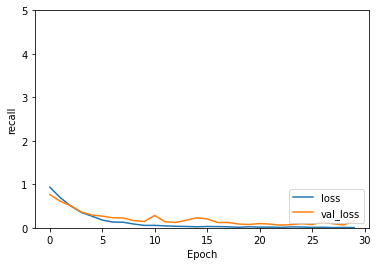

In [29]:
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 5])
plt.legend(loc='lower right')
plt.show()

### Save the Model

In [30]:

model.save("F:\\MRI_class\\data\\Alzheimer_s Dataset_20percentVal\\randomtest\\")
model.save("F:\\MRI_class\\data\\Alzheimer_s Dataset_20percentVal\\randomtest\\h5\\model_1.h5")

INFO:tensorflow:Assets written to: F:\MRI_class\data\Alzheimer_s Dataset_20percentVal\randomtest\assets


INFO:tensorflow:Assets written to: F:\MRI_class\data\Alzheimer_s Dataset_20percentVal\randomtest\assets


### Load a Testset

In [31]:
oasis_img_temp, oasis_label_temp = load_oasis_set_win()

MemoryError: Unable to allocate 96.8 MiB for an array with shape (231, 208, 176, 3) and data type float32

### Get only classes 0, 1 and 2 of the Testset

In [23]:
oasis_images = []
oasis_labels = []
for image,label in zip(oasis_img_temp,oasis_label_temp):
    if int(label) == 3:
        continue
    if int(label) == 0:
        #image = image/255
        oasis_images.append(cv2.flip(image,0))
        oasis_labels.append([1,0,0])
    if int(label) == 1:
        #image = image/255
        oasis_images.append(cv2.flip(image,0))
        oasis_labels.append([0,1,0])
    if int(label) == 2:
        #image = image/255
        oasis_images.append(cv2.flip(image,0))
        oasis_labels.append([0,0,1])

oasis_images = np.array(oasis_images)
oasis_labels = np.array(oasis_labels)
        

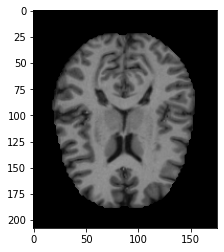

In [24]:
plt.imshow(oasis_images[0].astype("uint8"))

### Perform a Prediction on the Testset and Visualize the Results

In [25]:
oasis_pred = model.predict(oasis_images, batch_size=1)

229/229 [==============================] - 1s 4ms/step


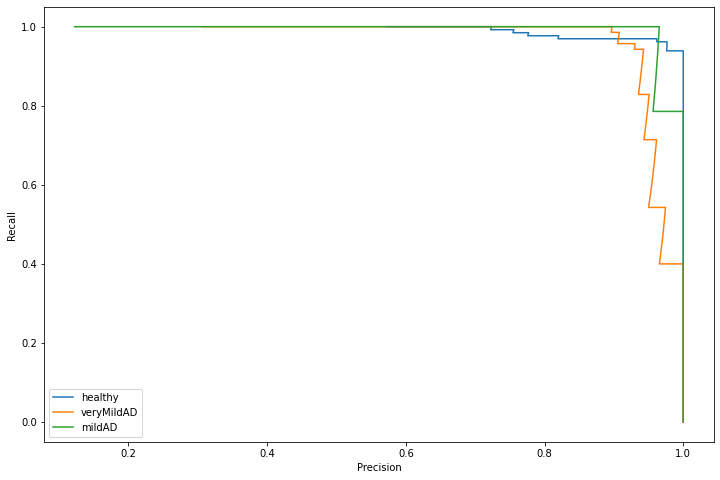

-----Recalls-----
healthy Recall: 0.8549618320610687
veryMildAD Recall: 1.0
mildAD Recall: 0.8928571428571429
-------#####-------


-----Precisions-----
healthy Precision: 1.0
veryMildAD Precision: 0.7692307692307693
mildAD Precision: 0.9615384615384616
-------#####-------


-----Accuracy-----
healthy Accuracy: 1.0
veryMildAD Accuracy: 0.7692307692307693
mildAD Accuracy: 0.9615384615384616
-------#####-------


-----Macro/Micro Recall and Precisions-----
Macro recall: 0.9159396583060705 Micro recall: 0.9039301310043668
Macro precision: 0.9102564102564102 Micro precision: 0.9039301310043668
------------#####------------


In [26]:
precision_recall_multiclass(oasis_pred,oasis_labels,["healthy","veryMildAD","mildAD"])

In [27]:
# load validation dataset from drive
# set for training
tf.random.set_seed(10)
PATH = "F:\\MRI_class\\data\\realTest3"
IMAGE_SIZE = (208,176)
test_ds = tf.keras.utils.image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
test_fullTensor = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
#test_fullTensor = test_ds.map(lambda x, y: ((x - tf.math.reduce_mean(x)) / tf.math.reduce_std(x), tf.one_hot(y, depth=3)))

Found 1267 files belonging to 3 classes.


In [28]:
test_images = []
test_labels = []
for image,label in test_fullTensor.unbatch():
    
    test_images.append(image.numpy())
    test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

MemoryError: Unable to allocate 531. MiB for an array with shape (1267, 208, 176, 3) and data type float32

In [ ]:
y_pred = model.predict(test_images, batch_size=1)

1267/1267 [==============================] - 5s 4ms/step


In [ ]:
model.evaluate(test_fullTensor)

40/40 [==============================] - 2s 50ms/step - loss: 1.9892 - precision: 0.7433 - recall: 0.7427 - auc: 0.8565


[1.9891842603683472,
 0.7432859539985657,
 0.7426992654800415,
 0.8565223813056946]

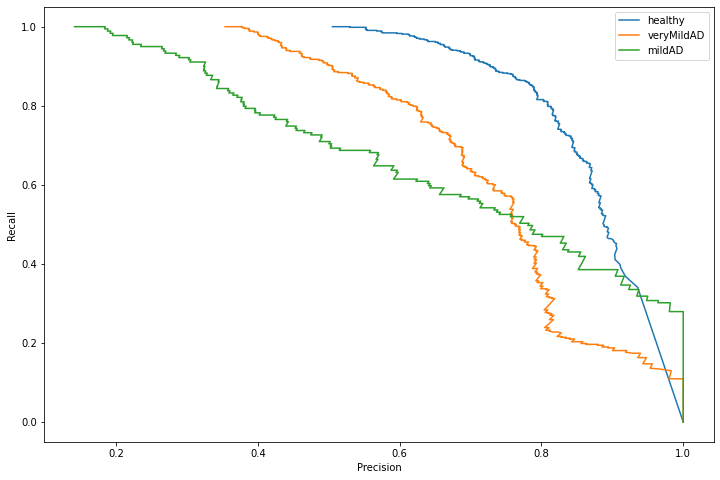

-----Recalls-----
healthy Recall: 0.88125
veryMildAD Recall: 0.6875
mildAD Recall: 0.3687150837988827
-------#####-------


-----Precisions-----
healthy Precision: 0.7540106951871658
veryMildAD Precision: 0.6890380313199105
mildAD Precision: 0.9166666666666666
-------#####-------


-----Accuracy-----
healthy Accuracy: 0.7540106951871658
veryMildAD Accuracy: 0.6890380313199105
mildAD Accuracy: 0.9166666666666666
-------#####-------


-----Macro/Micro Recall and Precisions-----
Macro recall: 0.6458216945996276 Micro recall: 0.7403314917127072
Macro precision: 0.786571797724581 Micro precision: 0.7403314917127072
------------#####------------


In [ ]:
precision_recall_multiclass(y_pred,test_labels,["healthy","veryMildAD","mildAD"])

MACRO ROC AUC SCORE: 0.7447950471929147


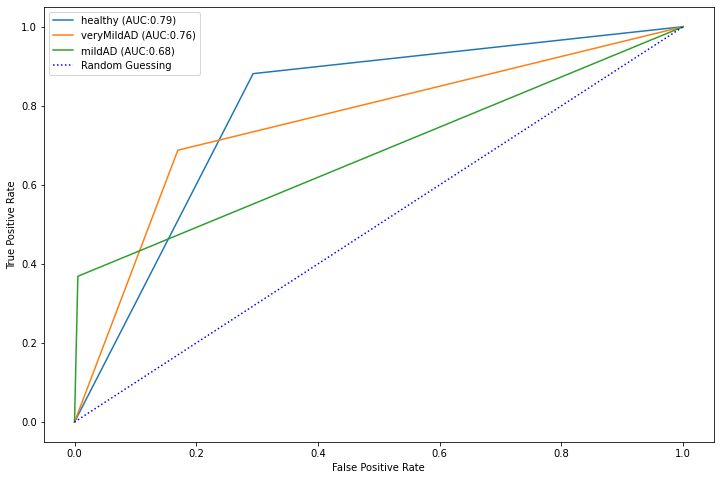

In [ ]:
roc_multiclass(y_pred,test_labels,["healthy","veryMildAD","mildAD"],"macro")